# **Goals**

Sometimes we want to save memories to a [collection](https://docs.google.com/presentation/d/181mvjlgsnxudQI6S3ritg9sooNyu4AcLLFH1UK0kIuk/edit#slide=id.g30eb3c8cf10_0_200) rather than single profile. 

Here we'll update our chatbot to [save memories to a collection](https://langchain-ai.github.io/langgraph/concepts/memory/#collection).

We'll also show how to use [Trustcall](https://github.com/hinthornw/trustcall) to update this collection. 


In [1]:
from IPython.display import display, Image
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.store.base import BaseStore

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig
load_dotenv()
import os

os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

groq_api_key = os.getenv("GROQ_API_KEY")

model = ChatGroq(model_name = "meta-llama/llama-4-scout-17b-16e-instruct", groq_api_key=groq_api_key)

## Defining a collection schema

Instead of storing user information in a fixed profile structure, we'll create a flexible collection schema to store memories about user interactions.

Each memory will be stored as a separate entry with a single `content` field for the main information we want to remember

This approach allows us to build an open-ended collection of memories that can grow and change as we learn more about the user.

We can define a collection schema as a [Pydantic](https://docs.pydantic.dev/latest/) object. 

In [46]:
from pydantic import BaseModel, Field

class Memory(BaseModel):
    """Tool for storing information about the user for long-term memory."""
    
    content: str = Field(description="The main content of the memory. For example: User expressed interest in learning about French.")

class MemoryCollection(BaseModel):
    # """Tool for storing information about the user for long-term memory."""
    
    memories: list[Memory] = Field(description="A list of memories about the user.")

In [51]:
from langchain_core.messages import HumanMessage, SystemMessage

model_with_structure = model.with_structured_output(MemoryCollection)

# Invoke the model to produce structured output that matches the schema
memory_collection = model_with_structure.invoke([HumanMessage("My name is Al Amin. I like bike.")])
memory_collection.memories

[Memory(content="User's name is Al Amin."), Memory(content='User likes bike.')]

In [52]:
memory_collection.memories[0].model_dump()

{'content': "User's name is Al Amin."}

In [53]:
memory_collection.memories[1].model_dump()

{'content': 'User likes bike.'}

### Save dictionary representation of each memory to the store.

In [54]:
from langgraph.store.memory import InMemoryStore
import uuid
in_memory_store = InMemoryStore()

user_id = '1'
namespace_for_memory = (user_id, "memories")

key = str(uuid.uuid4())
value = memory_collection.memories[0].model_dump()
in_memory_store.put(namespace_for_memory, key, value)

key = str(uuid.uuid4())
value = memory_collection.memories[1].model_dump()
in_memory_store.put(namespace_for_memory, key, value)

In [55]:
# Search 
for m in in_memory_store.search(namespace_for_memory):
    print(m.dict())

{'namespace': ['1', 'memories'], 'key': 'aa765124-817e-43b4-b1a8-125d5d28a13f', 'value': {'content': "User's name is Al Amin."}, 'created_at': '2025-05-13T05:57:07.259249+00:00', 'updated_at': '2025-05-13T05:57:07.259249+00:00', 'score': None}
{'namespace': ['1', 'memories'], 'key': '4233b6cf-9517-476d-babb-cb117c78faac', 'value': {'content': 'User likes bike.'}, 'created_at': '2025-05-13T05:57:07.259249+00:00', 'updated_at': '2025-05-13T05:57:07.259249+00:00', 'score': None}


## ***Updating collection schema***

We discussed the challenges with updating a profile schema in the last lesson. 

The same applies for collections! 

We want the ability to update the collection with new memories as well as update existing memories in the collection. 

Now we'll show that [Trustcall](https://github.com/hinthornw/trustcall) can be also used to update a collection. 

This enables both addition of new memories as well as [updating existing memories in the collection](https://github.com/hinthornw/trustcall?tab=readme-ov-file#simultanous-updates--insertions
).

Let's define a new extractor with Trustcall. 

As before, we provide the schema for each memory, `Memory`.  

But, we can supply `enable_inserts=True` to allow the extractor to insert new memories to the collection. 

In [56]:
from trustcall import create_extractor

# Create the extractor
trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    tool_choice="Memory",
    enable_inserts=True,
)

In [57]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

# Instruction
instruction = """Extract memories from the following conversation:"""

# Conversation
conversation = [HumanMessage(content="Hi, I'm Al Amin."), 
                AIMessage(content="Nice to meet you, Al Amin."), 
                HumanMessage(content="This morning I had a nice bike ride in Bashundhara r/a, Dhaka.")]

# Invoke the extractor
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=instruction)] + conversation})

#### above error by model.But code is correct. hare need `gpt-4o` model.

In [58]:
# Messages contain the tool calls
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_6tzp)
 Call ID: call_6tzp
  Args:
    content: Al Amin had a bike ride in Bashundhara r/a, Dhaka.


In [59]:
# Responses contain the memories that adhere to the schema
for m in result["responses"]: 
    print(m)

content='Al Amin had a bike ride in Bashundhara r/a, Dhaka.'


In [60]:
# Metadata contains the tool call  
for m in result["response_metadata"]: 
    print(m)

{'id': 'call_6tzp'}


In [61]:
# Update the conversation
updated_conversation = [AIMessage(content="That's great, did you do after?"), 
                        HumanMessage(content="I went to Tartine and ate a croissant."),                        
                        AIMessage(content="What else is on your mind?"),
                        HumanMessage(content="I was thinking about my Japan, and going back this winter!"),]

# Update the instruction
system_msg = """Update existing memories and create new ones based on the following conversation:"""

# We'll save existing memories, giving them an ID, key (tool name), and value
tool_name = "Memory"
existing_memories = [(str(i), tool_name, memory.model_dump()) for i, memory in enumerate(result["responses"])] if result["responses"] else None
existing_memories

[('0',
  'Memory',
  {'content': 'Al Amin had a bike ride in Bashundhara r/a, Dhaka.'})]

In [62]:
# Invoke the extractor with our updated conversation and existing memories
result = trustcall_extractor.invoke({"messages": updated_conversation, 
                                     "existing": existing_memories})

In [63]:
# Messages from the model indicate two tool calls were made
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_bqkh)
 Call ID: call_bqkh
  Args:
    content: Al Amin had a bike ride in Bashundhara r/a, Dhaka. He went to Tartine and ate a croissant. He was thinking about Japan and going back this winter.


In [64]:
# Responses contain the memories that adhere to the schema
for m in result["responses"]: 
    print(m)

content='Al Amin had a bike ride in Bashundhara r/a, Dhaka. He went to Tartine and ate a croissant. He was thinking about Japan and going back this winter.'


In [65]:
# Metadata contains the tool call  
for m in result["response_metadata"]: 
    print(m)

{'id': 'call_bqkh'}


## Chatbot with collection schema updating

---



Now, let's bring Trustcall into our chatbot to create and update a memory collection.

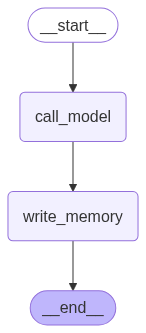

In [66]:
from IPython.display import Image, display
import uuid
from typing import List
from pydantic import BaseModel, Field

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.memory import InMemoryStore
from langchain_core.messages import merge_message_runs
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore
from langchain_groq import ChatGroq
# from langgraph.prebuilt import create_extractor

# Initialize the model
model = ChatGroq(model_name = "meta-llama/llama-4-scout-17b-16e-instruct", groq_api_key=groq_api_key)

# Memory schema with proper description
class Memory(BaseModel):
    """Tool for storing information about the user for long-term memory."""
    
    content: str = Field(
        description="The main content of the memory. For example: User expressed interest in learning about French."
    )

# Create the Trustcall extractor
trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    tool_choice="Memory",
    # This allows the extractor to insert new memories
    enable_inserts=True,
)

# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful chatbot. You are designed to be a companion to a user. 

You have a long term memory which keeps track of information you learn about the user over time.

Current Memory (may include updated memories from this conversation): 

{memory}"""

# Trustcall instruction
TRUSTCALL_INSTRUCTION = """Reflect on following interaction. 

Use the provided tools to retain any necessary memories about the user. 

Use parallel tool calling to handle updates and insertions simultaneously:"""

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """Load memories from the store and use them to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memories", user_id)
    memories = store.search(namespace)

    # Format the memories for the system prompt
    info = "\n".join(f"- {mem.value['content']}" for mem in memories)
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=info)

    # Respond using memory as well as the chat history
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("memories", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "Memory"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )

    # Merge the chat history and the instruction
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION)] + state["messages"]))

    # Invoke the extractor
    result = trustcall_extractor.invoke({"messages": updated_messages, 
                                        "existing": existing_memories})

    # Save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )

# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [72]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "3", "user_id": "3"}}

# User input 
input_messages = [HumanMessage(content="Assalamualikum, i'm Al Amin")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Assalamualikum, i'm Al Amin
================================== Ai Message ==================================

Wa alaikumussalam, Al Amin! It's nice to meet you. I'm here to chat and help with any questions or topics you'd like to discuss. How are you doing today? 

(By the way, I'll make sure to remember your name, Al Amin, for our future conversations!)


In [73]:
# User input 
input_messages = [HumanMessage(content="I like to bike Bashundhara r/a, Dhaka")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to bike Bashundhara r/a, Dhaka
================================== Ai Message ==================================

Bashundhara Residential Area in Dhaka is a lovely place to bike around. The roads are relatively smooth, and it's a great way to explore the area. Are you a regular biker, Al Amin? Do you have a favorite route or spot in Bashundhara R/A that you like to visit on your bike?


In [74]:
# Namespace for the memory to save
user_id = "3"
namespace = ("memories", user_id)
memories = across_thread_memory.search(namespace)
for m in memories:
    print(m.dict())

{'namespace': ['memories', '3'], 'key': 'd05fee14-1d56-4c38-b82d-de345c40096a', 'value': {'content': 'User introduced himself as Al Amin.'}, 'created_at': '2025-05-13T06:02:37.108009+00:00', 'updated_at': '2025-05-13T06:02:37.108009+00:00', 'score': None}
{'namespace': ['memories', '3'], 'key': 'fec93391-d275-40af-83f2-50a94ece93bf', 'value': {'content': 'Al Amin likes biking in Bashundhara r/a, Dhaka.'}, 'created_at': '2025-05-13T06:02:54.687744+00:00', 'updated_at': '2025-05-13T06:02:54.687744+00:00', 'score': None}


In [75]:
# User input 
input_messages = [HumanMessage(content="I also enjoy going to bakeries")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I also enjoy going to bakeries
================================== Ai Message ==================================

A sweet tooth, Al Amin? Bakeries can be a wonderful treat. Are you particularly fond of any specific types of baked goods, like pastries, cakes, or bread? Or are there any bakeries in Dhaka that you especially enjoy visiting? 

(By the way, I recall you mentioned biking in Bashundhara R/A earlier. Maybe you've stopped by a bakery or two after a ride?)


## Chat with a new Thread

In [77]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "4", "user_id": "3"}}

# User input 
input_messages = [HumanMessage(content="What bakeries do you recommend for me?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What bakeries do you recommend for me?
================================== Ai Message ==================================

Al Amin, that's you! I recall that you mentioned enjoying bakeries in Bashundhara r/a, Dhaka. Unfortunately, I don't have specific bakery recommendations stored in my memory. However, I can suggest that you try searching online for highly-rated bakeries in Bashundhara r/a, Dhaka. You can also ask locals or check social media for recommendations.

That being said, I can try to help you brainstorm or provide general information about bakeries. Would you like me to do that?


In [78]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "4", "user_id": "3"}}

# User input 
input_messages = [HumanMessage(content="What Restaurant do you recommend for me?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What Restaurant do you recommend for me?
================================== Ai Message ==================================

As Al Amin, I recall that you enjoy biking in Bashundhara r/a, Dhaka. If you're looking for a restaurant recommendation, I'd be happy to help. However, I don't have specific restaurant recommendations stored in my memory.

That being said, since you mentioned you enjoy bakeries, I can suggest looking for restaurants that have a bakery or café attached to them. Alternatively, you can try searching online for highly-rated restaurants in Bashundhara r/a, Dhaka.

If you'd like, I can also try to provide general information about restaurants in the area or help you brainstorm options. Would you like me to do that?


In [79]:
input_messages = [HumanMessage(content="Can you tell some name its helps a lot?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Can you tell some name its helps a lot?
================================== Ai Message ==================================

As Al Amin, I recall that you were looking for bakery and restaurant recommendations in Bashundhara r/a, Dhaka. While I don't have a comprehensive list, I can suggest a few options that might be worth trying:

For bakeries:

* Impress Bakery (I've heard it's a popular spot)
* Bashundhara Bakery (conveniently located in the area)
* Apollo Bakery (known for their delicious treats)

For restaurants:

* The Bashundhara (a restaurant with a variety of cuisines)
* The Coffee Bean & Tea Leaf (a great spot for coffee and snacks)
* Some popular food courts or cafes in the Bashundhara r/a area

Keep in mind that these are just suggestions, and you may want to check reviews or ask locals for more recommendations. I hope this helps, and I'm happy to try to provide more information if you need it!


In [80]:
# Namespace for the memory to save
user_id = "3"
namespace = ("memories", user_id)
memories = across_thread_memory.search(namespace)
for m in memories:
    print(m.dict())

{'namespace': ['memories', '3'], 'key': 'd05fee14-1d56-4c38-b82d-de345c40096a', 'value': {'content': 'User introduced himself as Al Amin.'}, 'created_at': '2025-05-13T06:02:37.108009+00:00', 'updated_at': '2025-05-13T06:02:37.108009+00:00', 'score': None}
{'namespace': ['memories', '3'], 'key': 'fec93391-d275-40af-83f2-50a94ece93bf', 'value': {'content': 'Al Amin likes biking in Bashundhara r/a, Dhaka.'}, 'created_at': '2025-05-13T06:02:54.687744+00:00', 'updated_at': '2025-05-13T06:02:54.687744+00:00', 'score': None}
{'namespace': ['memories', '3'], 'key': '61868eee-0264-4d48-869b-eaa29119caf1', 'value': {'content': 'Al Amin enjoys biking in Bashundhara r/a, Dhaka and likes bakeries.'}, 'created_at': '2025-05-13T06:03:23.141822+00:00', 'updated_at': '2025-05-13T06:03:23.141822+00:00', 'score': None}
{'namespace': ['memories', '3'], 'key': '793e0070-df1f-4aea-b4da-3647771a21ae', 'value': {'content': 'User asked for bakery recommendations.'}, 'created_at': '2025-05-13T06:03:47.819591+00